In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import preproc_sheet, get_wide_df, refnis_to_arrondissment, get_arrondissement_from_code, prov_to_region
from utils import arrond_to_prov

pd.set_option('display.max_colwidth', 200)

In [32]:
excell_file = "FR_immo_statbel_trimestre_par_commune.xlsx"
excell_df   = pd.read_excel(excell_file)

In [33]:
dfs = preproc_sheet(excell_df)
df = get_wide_df(dfs)
df["arrond"] = df.refnis.apply(refnis_to_arrondissment)
df.head()

,refnis,commune,year,period,n_0,q2_0,q1_0,q3_0,n_1,q2_1,...,q3_1,n_2,q2_2,q1_2,q3_2,n_3,q2_3,q1_3,q3_3,arrond
0,11001,AARTSELAAR,2010,Q1,29,252000,225000,290000,25,247000,...,265000,4,NaN,NaN,NaN,9,NaN,NaN,NaN,11
1,11001,AARTSELAAR,2010,Q2,25,254000,212000,289000,20,251250,...,275000,5,NaN,NaN,NaN,11,NaN,NaN,NaN,11
2,11001,AARTSELAAR,2010,Q3,21,255000,235000,285000,18,250000,...,275000,3,NaN,NaN,NaN,9,NaN,NaN,NaN,11
3,11001,AARTSELAAR,2010,Q4,28,245000,210000,312500,21,245000,...,280000,7,NaN,NaN,NaN,13,NaN,NaN,NaN,11
4,11001,AARTSELAAR,2011,Q1,23,310000,220000,370000,18,280000,...,360000,5,NaN,NaN,NaN,10,NaN,NaN,NaN,11


# Impute n_i NaNs with 0s

In [34]:
from sklearn.impute import SimpleImputer 

impute = SimpleImputer(strategy="constant",fill_value=0)

df[["n_0","n_1","n_2","n_3"]] = impute.fit_transform(df[["n_0","n_1","n_2","n_3"]])
#df.n_1 = df.n_1.apply(lambda x: 0 if pd.isna(x) else x)
#df.n_2 = df.n_2.apply(lambda x: 0 if pd.isna(x) else x)
#df.n_0 = df.n_0.apply(lambda x: 0 if pd.isna(x) else x)
#df.n_3 = df.n_3.apply(lambda x: 0 if pd.isna(x) else x)


### Confirm n_1+n_2 =n_0 after imputation

In [35]:
df["n"] = df.n_1 + df.n_2
assert len(df[df.n_0 != df.n]) == 0

### Confirm that there are NaNs in quartile prices when n is 0

In [36]:
# If the n_trans is 0, there should be no median price
for i in range(4): 
    col1 = f"n_{i}"
    col2 = f"q1_{i}"
    col3 = f"q2_{i}"
    col4 = f"q3_{i}"

    l1 = len(df[(df[col1]==0)])
    l2 = len(df[(df[col1]==0) & df[col2].isna() ])

    l0_1 = len(df[(df[col1]==0) & df[col2].notna() ])
    l0_2 = len(df[(df[col1]==0) & df[col3].notna() ])
    l0_3 = len(df[(df[col1]==0) & df[col4].notna() ])

    assert l1 == l2
    assert l0_1 == l0_2 == l0_3 == 0 

## Confirm assumptions on n_trans via aggregation comparison

- find a year where there are nans
- add up the ns assuming 0 for the nans
- looking at the yearly excell, confirm the sums you have calculated

In [37]:
df[df.n_0==0].head(7)

,refnis,commune,year,period,n_0,q2_0,q1_0,q3_0,n_1,q2_1,...,n_2,q2_2,q1_2,q3_2,n_3,q2_3,q1_3,q3_3,arrond,n
2505,13002,BAERLE-DUC,2011,Q1,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,0,NaN,NaN,NaN,13,0
2514,13002,BAERLE-DUC,2013,Q2,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,3,NaN,NaN,NaN,13,0
2515,13002,BAERLE-DUC,2013,Q3,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,1,NaN,NaN,NaN,13,0
2522,13002,BAERLE-DUC,2015,Q2,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,0,NaN,NaN,NaN,13,0
2553,13002,BAERLE-DUC,2023,Q1,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,0,NaN,NaN,NaN,13,0
5385,23009,BIEVENE,2014,Q2,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,0,NaN,NaN,NaN,23,0
5389,23009,BIEVENE,2015,Q2,0,NaN,NaN,NaN,0,NaN,...,0,NaN,NaN,NaN,0,NaN,NaN,NaN,23,0


In [38]:
baerle_ref = 13002
baerle = df[df.refnis==baerle_ref].copy()
baerle = baerle[["year", "refnis", "commune", "n_0","n_1","n_2","n_3"]].groupby(by=["year","refnis","commune"]).sum().reset_index()
baerle.sort_values(by="year",ascending=True)
baerle = baerle.drop(15, axis=0)  # need full year so drop 2025
baerle.index = baerle.refnis
baerle.drop("refnis",axis=1,inplace=True)
baerle.head(18)


,year,commune,n_0,n_1,n_2,n_3
refnis,,,,,,
13002,2010,BAERLE-DUC,17,13,4,4
13002,2011,BAERLE-DUC,11,9,2,1
13002,2012,BAERLE-DUC,11,9,2,2
13002,2013,BAERLE-DUC,6,2,4,8
13002,2014,BAERLE-DUC,18,12,6,3
13002,2015,BAERLE-DUC,9,7,2,3
13002,2016,BAERLE-DUC,16,12,4,1
13002,2017,BAERLE-DUC,21,14,7,4
13002,2018,BAERLE-DUC,23,11,12,11


In [39]:
ref_file = "FR_immo_statbel_annee.xlsx"
excell_df   = pd.read_excel(ref_file,sheet_name = "Par commune")
year_dfs    = preproc_sheet(excell_df)
year_df     = get_wide_df(year_dfs)

year_df.n_1 = year_df.n_1.apply(lambda x: 0 if pd.isna(x) else x)
year_df.n_2 = year_df.n_2.apply(lambda x: 0 if pd.isna(x) else x)
year_df.n_0 = year_df.n_0.apply(lambda x: 0 if pd.isna(x) else x)
year_df.n_3 = year_df.n_3.apply(lambda x: 0 if pd.isna(x) else x)

year_df.index = year_df.refnis
q_cols = [col for col in year_df.columns if "q" in col]
year_df.drop(["period"]+q_cols,axis=1,inplace=True)

In [40]:
baerle_year = year_df.loc[year_df.refnis==baerle_ref, ["refnis","commune", "year","n_0","n_1","n_2","n_3"]].copy()
baerle_year.sort_values(by="year",inplace=True)
baerle_year.index = baerle_year.refnis
baerle_year.drop("refnis",axis=1,inplace=True)
baerle_year

,commune,year,n_0,n_1,n_2,n_3
refnis,,,,,,
13002,BAERLE-DUC,2010,17,13,4,4
13002,BAERLE-DUC,2011,11,9,2,1
13002,BAERLE-DUC,2012,11,9,2,2
13002,BAERLE-DUC,2013,6,2,4,8
13002,BAERLE-DUC,2014,18,12,6,3
13002,BAERLE-DUC,2015,9,7,2,3
13002,BAERLE-DUC,2016,16,12,4,1
13002,BAERLE-DUC,2017,21,14,7,4
13002,BAERLE-DUC,2018,23,11,12,11


In [41]:
assert all(baerle_year[["n_0","n_1","n_2","n_3"]] == baerle[["n_0","n_1","n_2","n_3"]])
assert np.array_equal(baerle_year[["n_0","n_1","n_2","n_3"]].values , baerle[["n_0","n_1","n_2","n_3"]].values)

### general test

In [42]:
agg_df = df.loc[ df.year!=2025,["year", "refnis", "commune", "n_0","n_1","n_2","n_3"]].groupby(by=["year","refnis","commune"]).sum().reset_index()
agg_df.sort_values(by=["refnis","year"],ascending=True,inplace=True)
agg_df.index =agg_df.refnis
agg_df.drop("refnis", axis=1,inplace=True)
agg_df.head(4)

,year,commune,n_0,n_1,n_2,n_3
refnis,,,,,,
11001,2010,AARTSELAAR,103,84,19,42
11001,2011,AARTSELAAR,100,74,26,44
11001,2012,AARTSELAAR,100,77,23,65
11001,2013,AARTSELAAR,91,74,17,47


In [43]:
test_baerle = all(agg_df.loc[baerle_ref, ["n_0","n_1","n_2","n_3"]] == year_df.loc[baerle_ref, ["n_0","n_1","n_2","n_3"]])
test_all = all(agg_df[["n_0","n_1","n_2","n_3"]] == year_df[ ["n_0","n_1","n_2","n_3"]])
test_all_2 = np.array_equal(  agg_df[["n_0","n_1","n_2","n_3"]].values , year_df[ ["n_0","n_1","n_2","n_3"]].values )
test_baerle, test_all, test_all_2

(True, True, True)

# Belgium Wide transaction plots

In [44]:
excell_df    = pd.read_excel(ref_file,sheet_name = "La Belgique")
belg_dfs     = preproc_sheet(excell_df)
belg_year_df = get_wide_df(belg_dfs)
belg_year_df.index = belg_year_df.year
q_cols = [col for col in belg_year_df.columns if "q" in col ]
belg_year_df.drop(["year","refnis","period","commune"]+q_cols,axis=1,inplace=True)
belg_year_df.head()

,n_0,n_1,n_2,n_3
year,,,,
2010,78871,54877,23994,26822
2011,82895,58224,24671,30419
2012,77402,54004,23398,29791
2013,76073,52534,23539,29049
2014,87944,60242,27702,32406


In [45]:
yearly_sales_number = agg_df[["year","n_0","n_1","n_2","n_3"]].groupby(["year"]).sum()
assert all(yearly_sales_number[["n_0","n_1","n_2","n_3"]] == belg_year_df[["n_0","n_1","n_2","n_3"]])
assert np.array_equal(yearly_sales_number[["n_0","n_1","n_2","n_3"]].values , belg_year_df[["n_0","n_1","n_2","n_3"]].values)

In [46]:
yearly_sales_number.columns = ["all_houses",  "attached_houses", "detached_houses","Appartment"]
yearly_sales_number

,all_houses,attached_houses,detached_houses,Appartment
year,,,,
2010,78871,54877,23994,26822
2011,82895,58224,24671,30419
2012,77402,54004,23398,29791
2013,76073,52534,23539,29049
2014,87944,60242,27702,32406
2015,74114,50208,23906,29403
2016,85875,58390,27485,33189
2017,88914,60524,28390,34938
2018,93381,62897,30484,36947


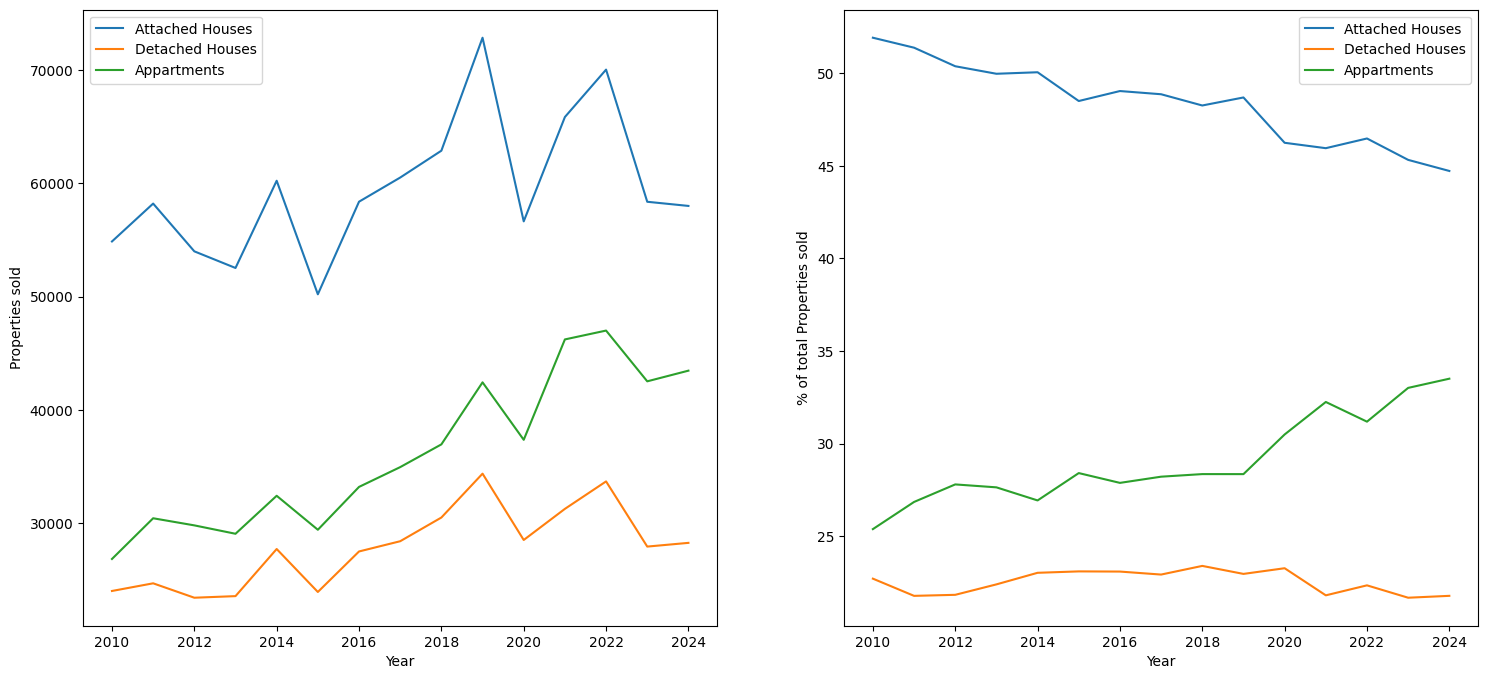

In [47]:
fig, axes = plt.subplots(1,2,figsize=(18,8))

total_sold = (yearly_sales_number["attached_houses"] + yearly_sales_number["detached_houses"] + yearly_sales_number["Appartment"])
attached_frac   = 100* yearly_sales_number["attached_houses"] / total_sold
detached_frac   = 100* yearly_sales_number["detached_houses"] / total_sold
Appartment_frac = 100* yearly_sales_number["Appartment"]      / total_sold

axes[0].plot(yearly_sales_number["attached_houses"],label="Attached Houses");
axes[0].plot(yearly_sales_number["detached_houses"], label="Detached Houses");
axes[0].plot(yearly_sales_number["Appartment"], label="Appartments");
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Properties sold")
axes[0].legend()


axes[1].plot(attached_frac,label="Attached Houses");
axes[1].plot(detached_frac, label="Detached Houses");
axes[1].plot(Appartment_frac, label="Appartments");
axes[1].set_xlabel("Year")
axes[1].set_ylabel("% of total Properties sold")
axes[1].legend();

# Arrodisement stats per year

In [48]:
excell_df   = pd.read_excel(ref_file,sheet_name = "Par arrondissement")
arond_dfs   = preproc_sheet(excell_df)
arond_year_ref = get_wide_df(arond_dfs)

arond_year_ref["arrond"] = arond_year_ref.refnis.apply(lambda x: int(str(x)[:2]) )

test_arond_year = arond_year_ref[["arrond","year","n_0","n_1","n_2","n_3"]].sort_values(by=["arrond","year"]).reset_index(drop=True)
test_arond_year.columns = ["arrond","year","all_houses",  "attached_houses", "detached_houses","Appartment"]
test_arond_year.head(6)

,arrond,year,all_houses,attached_houses,detached_houses,Appartment
0,11,2010,6599,5158,1441,5266
1,11,2011,6929,5442,1487,5668
2,11,2012,6393,4941,1452,5461
3,11,2013,6471,5007,1464,5424
4,11,2014,7944,6103,1841,6296
5,11,2015,6338,4859,1479,5224


In [49]:
df["arrond"] = df.refnis.apply(lambda x: int(str(x)[:2]) )
arrond_per_quarter = df[["year", "period","arrond", "n_0","n_1","n_2","n_3"]].groupby(["year","period", "arrond"]).sum().reset_index()
arrond_per_quarter.sort_values(by=["arrond","year","period"], ascending=True,inplace=True)
arrond_per_quarter.head(4)

,year,period,arrond,n_0,n_1,n_2,n_3
0,2010,Q1,11,1566,1243,323,1218
43,2010,Q2,11,1697,1321,376,1431
86,2010,Q3,11,1783,1376,407,1285
129,2010,Q4,11,1553,1218,335,1332


In [50]:
arrond_per_year = (
    arrond_per_quarter.loc[arrond_per_quarter.year!=2025, ["year","arrond","n_0","n_1","n_2","n_3"]]
    .groupby(["arrond","year"])
    .sum()
    .reset_index() )
arrond_per_year.columns = ["arrond","year","all_houses",  "attached_houses", "detached_houses","Appartment"]
arrond_per_year = arrond_per_year.sort_values(by=["arrond","year"]).reset_index(drop=True)
arrond_per_year.head(5)

,arrond,year,all_houses,attached_houses,detached_houses,Appartment
0,11,2010,6599,5158,1441,5266
1,11,2011,6929,5442,1487,5668
2,11,2012,6393,4941,1452,5461
3,11,2013,6471,5007,1464,5424
4,11,2014,7944,6103,1841,6296


In [51]:
assert all(test_arond_year == arrond_per_year)
assert np.array_equal(test_arond_year.values , arrond_per_year.values)

# Province per year

In [52]:
df["prov"] = df.arrond.apply(arrond_to_prov)
arrond_per_year["prov"] = arrond_per_year["arrond"].apply(arrond_to_prov)
#arrond_per_year[["arrond","prov"]].drop_duplicates()

prov_per_year = (
    arrond_per_year.loc[arrond_per_year.prov !=0, ["prov","year","all_houses","attached_houses","detached_houses","Appartment"]]
    .groupby(["prov","year"])
    .sum()
    .reset_index()
    .sort_values(by=["prov","year"])
)
prov_per_year.sample(10).head(10)

,prov,year,all_houses,attached_houses,detached_houses,Appartment
56,30000,2021,13009,9579,3430,9273
28,20001,2023,9202,5573,3629,3214
59,30000,2024,11412,8245,3167,7031
122,80000,2012,2158,1019,1139,256
32,20002,2012,2896,1454,1442,728
31,20002,2011,2964,1500,1464,669
65,40000,2015,10793,8280,2513,2271
77,50000,2012,11591,9053,2538,1097
42,20002,2022,3280,1676,1604,1039
145,90000,2020,4319,2112,2207,629


In [53]:
excell_df     = pd.read_excel(ref_file,sheet_name = "Par province")
prov_dfs      = preproc_sheet(excell_df)
prov_year_ref = get_wide_df(prov_dfs)

q_cols = [col for col in prov_year_ref if "q" in col]
prov_year_ref = prov_year_ref.drop(["period"]+q_cols,axis=1)
prov_year_ref.columns = ["prov", "locale", "year", "all_houses",  "attached_houses", "detached_houses","Appartment"]
prov_year_ref.head(4)

,prov,locale,year,all_houses,attached_houses,detached_houses,Appartment
0,10000,PROVINCE D'ANVERS,2010,12202,8586,3616,6382
1,10000,PROVINCE D'ANVERS,2011,12843,9067,3776,7035
2,10000,PROVINCE D'ANVERS,2012,12082,8424,3658,6807
3,10000,PROVINCE D'ANVERS,2013,12019,8306,3713,6862


In [54]:
assert all(prov_per_year == prov_year_ref[["prov","year","all_houses","attached_houses", "detached_houses","Appartment"]])
assert np.array_equal(prov_per_year.values , prov_year_ref[["prov","year","all_houses","attached_houses", "detached_houses","Appartment"]].values)

# Region per year

In [55]:
excell_df       = pd.read_excel(ref_file,sheet_name = "Par région")
reg_dfs         = preproc_sheet(excell_df)
region_year_ref = get_wide_df(reg_dfs)

q_cols = [col for col in region_year_ref if "q" in col]
region_year_ref = region_year_ref.drop(["period"]+q_cols,axis=1)

region_year_ref.refnis = region_year_ref.refnis.apply(lambda x: "0"+str(x))
region_year_ref.columns = ["region_code","region", "year","n_0","n_1","n_2","n_3"]

#region_year_ref.sample(6).head(6)
region_year_ref.head(5)


,region_code,region,year,n_0,n_1,n_2,n_3
0,02000,REGION FLAMANDE,2010,47744,33288,14456,15822
1,02000,REGION FLAMANDE,2011,50679,35757,14922,18069
2,02000,REGION FLAMANDE,2012,47341,33169,14172,17459
3,02000,REGION FLAMANDE,2013,47223,32798,14425,17447
4,02000,REGION FLAMANDE,2014,57289,39527,17762,20065


In [56]:
df["region"] = df.prov.map(prov_to_region)

region_df = (
    df.loc[df.year!=2025, ["region","year", "n_0","n_1","n_2","n_3"]]
      .groupby(["region","year"])
      .sum()
      .reset_index()
      .sort_values(by=["region","year"])
)

region_df.columns = ["region_code", "year","n_0","n_1","n_2","n_3"]
region_df.head(4)

,region_code,year,n_0,n_1,n_2,n_3
0,02000,2010,47744,33288,14456,15822
1,02000,2011,50679,35757,14922,18069
2,02000,2012,47341,33169,14172,17459
3,02000,2013,47223,32798,14425,17447


In [57]:
assert all(region_df == region_year_ref[["region_code","year","n_0","n_1","n_2","n_3"]])
assert np.array_equal(region_df.values , region_year_ref[["region_code","year","n_0","n_1","n_2","n_3"]].values )